<a href="https://colab.research.google.com/github/vivaldydermagia123/project1_sales_forecasting/blob/main/Experiment_Sales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Understanding

## Feature Explanation



* store_nbr 		: Nama toko tempat produk terjual
* family 		: Jenis produk yang dijual di toko tersebut.
* sales 			: Jumlah penjualan produk pada satuan tertentu.
* onpromotion 	: Jumlah item produk yang dipromosikan.
* Dcoilwtico 		: Harga minyak mentah di West Texas Intermediate Cushing, Oklahoma
* Time Range		: 1 Jan 2013 - 15 Ags 2017 (Data harian)



## Family feature explanation

Feature family terdiri dar 33 category :
* AUTOMOTIVE                    
* HOME APPLIANCES               
* SCHOOL AND OFFICE SUPPLIES    
* PRODUCE                       
* PREPARED FOODS                
* POULTRY                       
* PLAYERS AND ELECTRONICS       
* PET SUPPLIES                  
* PERSONAL CARE                 
* MEATS                         
* MAGAZINES                     
* LIQUOR,WINE,BEER              
* LINGERIE                      
* LAWN AND GARDEN               
* LADIESWEAR                    
* HOME CARE                     
* HOME AND KITCHEN II           
* BABY CARE                     
* HOME AND KITCHEN I            
* HARDWARE                      
* GROCERY II                    
* GROCERY I                     
* FROZEN FOODS                  
* EGGS                          
* DELI                          
* DAIRY                         
* CLEANING                      
* CELEBRATION                   
* BREAD/BAKERY                  
* BOOKS                        
* BEVERAGES                     
* BEAUTY                        
* SEAFOOD                                           


## Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow import keras
from tensorflow.keras import metrics
import sklearn as sk
import keras

## EDA

Informasi tentang dataset yang digunakan

>[Information of dataset](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data)

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/CefiroMartha/Store5/refs/heads/main/store5.csv')
data.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,1452,2013-01-01,5,AUTOMOTIVE,0.0,0,NaN
1,1453,2013-01-01,5,BABY CARE,0.0,0,NaN
2,1454,2013-01-01,5,BEAUTY,0.0,0,NaN
3,1455,2013-01-01,5,BEVERAGES,0.0,0,NaN
4,1456,2013-01-01,5,BOOKS,0.0,0,NaN


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55572 entries, 0 to 55571
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           55572 non-null  int64  
 1   date         55572 non-null  object 
 2   store_nbr    55572 non-null  int64  
 3   family       55572 non-null  object 
 4   sales        55572 non-null  float64
 5   onpromotion  55572 non-null  int64  
 6   dcoilwtico   38379 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 3.0+ MB


In [ ]:
# melihat statistik deskriptive sederhana
col_num = [x for x in data.columns if data[x].dtype != 'object' and x not in ['id', 'date', 'store_nbr','family']]
data[col_num].describe()

,sales,onpromotion,dcoilwtico
count,55572.000000,55572.000000,38379.000000
mean,280.580231,2.687864,67.925589
std,652.588149,11.748996,25.666659
min,0.000000,0.000000,26.190000
25%,1.000000,0.000000,46.380000
50%,19.000000,0.000000,53.330000
75%,237.000000,0.000000,95.800000
max,8216.620000,182.000000,110.620000


In [ ]:
# melihat nilai unik dari setiap feature
def number_unique(df):
  for i in df.columns:
    print(f'kolom {i} memiliki {df[i].nunique()} nilai unik')

number_unique(data)

kolom id memiliki 55572 nilai unik
kolom date memiliki 1684 nilai unik
kolom store_nbr memiliki 1 nilai unik
kolom family memiliki 33 nilai unik
kolom sales memiliki 14753 nilai unik
kolom onpromotion memiliki 165 nilai unik
kolom dcoilwtico memiliki 994 nilai unik


In [ ]:
# Melihat jumlah dari setiap kategori di dalam feature
def number_counts(df):
  for i in df.columns:
    if i in ['id', 'date', 'store_nbr']:
      continue
    else:
      print(f'===========\n')
      print(f'kolom {i} \n{df[i].value_counts()}')

number_counts(data)


kolom family 
family
AUTOMOTIVE                    1684
HOME APPLIANCES               1684
SCHOOL AND OFFICE SUPPLIES    1684
PRODUCE                       1684
PREPARED FOODS                1684
POULTRY                       1684
PLAYERS AND ELECTRONICS       1684
PET SUPPLIES                  1684
PERSONAL CARE                 1684
MEATS                         1684
MAGAZINES                     1684
LIQUOR,WINE,BEER              1684
LINGERIE                      1684
LAWN AND GARDEN               1684
LADIESWEAR                    1684
HOME CARE                     1684
HOME AND KITCHEN II           1684
BABY CARE                     1684
HOME AND KITCHEN I            1684
HARDWARE                      1684
GROCERY II                    1684
GROCERY I                     1684
FROZEN FOODS                  1684
EGGS                          1684
DELI                          1684
DAIRY                         1684
CLEANING                      1684
CELEBRATION                   168

In [ ]:
# Cek Missing Value
data.isnull().sum()

,0
id,0
date,0
store_nbr,0
family,0
sales,0
onpromotion,0
dcoilwtico,17193


**Note** : niai o pada feature **sales & on promotion** bukan mengintepretasikan missing value

In [ ]:
# copy data asli ke df
df = data.copy()

# set df dengan drop [id, store_nbr] dan index adalah date
df.drop(columns=['id', 'store_nbr'], inplace=True)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.head()

,family,sales,onpromotion,dcoilwtico
date,,,,
2013-01-01,AUTOMOTIVE,0.0,0,NaN
2013-01-01,BABY CARE,0.0,0,NaN
2013-01-01,BEAUTY,0.0,0,NaN
2013-01-01,BEVERAGES,0.0,0,NaN
2013-01-01,BOOKS,0.0,0,NaN


##Automotive Category

In [ ]:
# Mengambil product penjualan automotive saja
df_automotive = df.loc[df['family']=='AUTOMOTIVE']
df_automotive.head()

,family,sales,onpromotion,dcoilwtico
date,,,,
2013-01-01,AUTOMOTIVE,0.0,0,NaN
2013-01-02,AUTOMOTIVE,6.0,0,93.14
2013-01-03,AUTOMOTIVE,4.0,0,92.97
2013-01-04,AUTOMOTIVE,6.0,0,93.12
2013-01-05,AUTOMOTIVE,4.0,0,NaN


In [ ]:
number_unique(df_automotive)

kolom family memiliki 1 nilai unik
kolom sales memiliki 20 nilai unik
kolom onpromotion memiliki 3 nilai unik
kolom dcoilwtico memiliki 994 nilai unik


In [ ]:
number_counts(df_automotive)


kolom family 
family
AUTOMOTIVE    1684
Name: count, dtype: int64

kolom sales 
sales
5.0     246
4.0     226
3.0     196
6.0     185
2.0     159
7.0     144
8.0     106
1.0      96
9.0      94
10.0     60
0.0      44
11.0     41
12.0     29
13.0     21
14.0     12
15.0     10
16.0      7
18.0      4
19.0      2
17.0      2
Name: count, dtype: int64

kolom onpromotion 
onpromotion
0    1666
1      17
2       1
Name: count, dtype: int64

kolom dcoilwtico 
dcoilwtico
93.12    4
47.72    4
60.01    4
46.02    4
96.44    4
        ..
95.54    1
94.35    1
96.40    1
93.97    1
47.57    1
Name: count, Length: 994, dtype: int64


In [ ]:
df_automotive.isnull().sum()

,0
family,0
sales,0
onpromotion,0
dcoilwtico,521


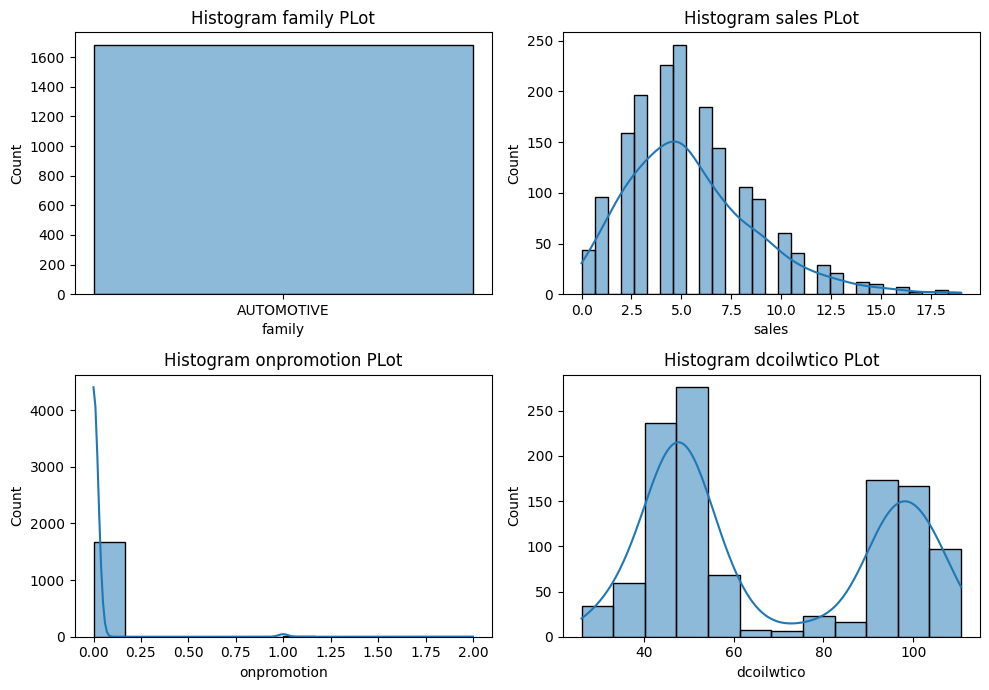

In [ ]:
def histo_plot(df):
  plt.figure(figsize=(10,7))
  for indx, i in enumerate(df.columns):
    plt.subplot(2,2, indx+1)
    sns.histplot(df[i], kde=True)
    plt.title(f'Histogram {i} PLot')
    plt.tight_layout()

  plt.show()

histo_plot(df_automotive)

In [ ]:
df_automotive['dcoilwtico_imputed'] =df_automotive['dcoilwtico'].interpolate()
df_automotive.dropna(subset=['dcoilwtico_imputed'], inplace=True)
df_automotive.head()

<ipython-input-62-6c968564af25>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_automotive['dcoilwtico_imputed'] =df_automotive['dcoilwtico'].interpolate()
<ipython-input-62-6c968564af25>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_automotive.dropna(subset=['dcoilwtico_imputed'], inplace=True)


,family,sales,onpromotion,dcoilwtico,dcoilwtico_imputed
date,,,,,
2013-01-02,AUTOMOTIVE,6.0,0,93.14,93.140000
2013-01-03,AUTOMOTIVE,4.0,0,92.97,92.970000
2013-01-04,AUTOMOTIVE,6.0,0,93.12,93.120000
2013-01-05,AUTOMOTIVE,4.0,0,NaN,93.146667
2013-01-06,AUTOMOTIVE,10.0,0,NaN,93.173333


### Imputasi Gaussian Mixture Model (GMM)

In [ ]:
# hapus Nan
dcoilwtico_clean = df_automotive[['dcoilwtico']].dropna()

# Clustering dcoilwtico
gmm = GaussianMixture(n_components=2, random_state=7)
gmm.fit(dcoilwtico_clean)
prediction_class = gmm.predict(dcoilwtico_clean)
df_automotive['cluster_dcoilwtico'] = pd.NA
df_automotive.loc[dcoilwtico_clean.index, 'cluster_dcoilwtico'] = prediction_class
df_automotive.head(10)

<ipython-input-63-0f8c5e6207d6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_automotive['cluster_dcoilwtico'] = pd.NA


,family,sales,onpromotion,dcoilwtico,dcoilwtico_imputed,cluster_dcoilwtico
date,,,,,,
2013-01-02,AUTOMOTIVE,6.0,0,93.14,93.140000,0
2013-01-03,AUTOMOTIVE,4.0,0,92.97,92.970000,0
2013-01-04,AUTOMOTIVE,6.0,0,93.12,93.120000,0
2013-01-05,AUTOMOTIVE,4.0,0,NaN,93.146667,<NA>
2013-01-06,AUTOMOTIVE,10.0,0,NaN,93.173333,<NA>
2013-01-07,AUTOMOTIVE,7.0,0,93.20,93.200000,0
2013-01-08,AUTOMOTIVE,5.0,0,93.21,93.210000,0
2013-01-09,AUTOMOTIVE,5.0,0,93.08,93.080000,0
2013-01-10,AUTOMOTIVE,2.0,0,93.81,93.810000,0


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

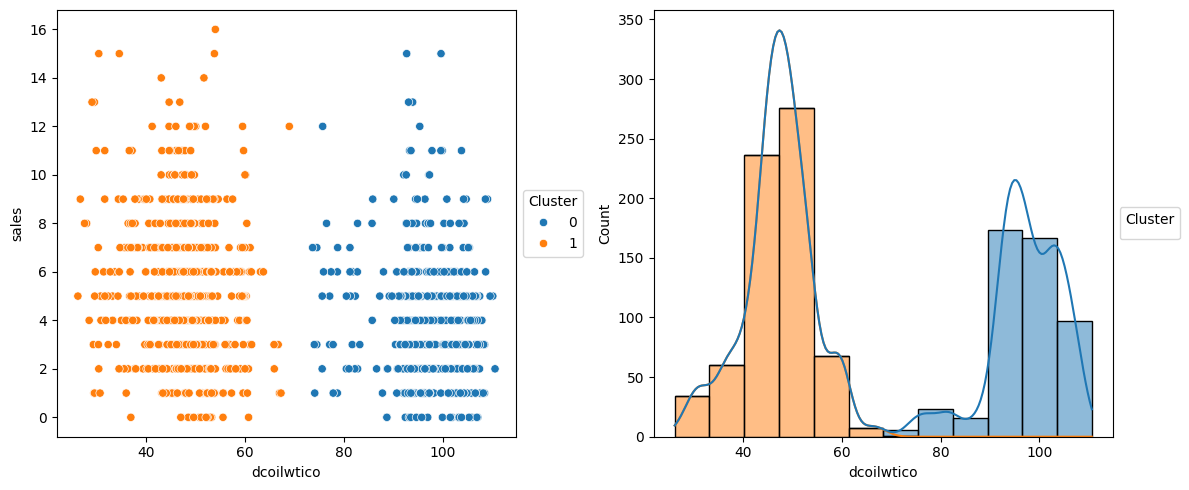

In [ ]:
# Menampilkan overview kolom dcoilwtico berdasarkan cluster
df_filtered = df_automotive.dropna(subset=['cluster_dcoilwtico'])

fig, ax = plt.subplots(1, 2, figsize=(12,5))

# Membuat scatter plot tanpa nilai NaN di 'hue'
sns.scatterplot(x=df_filtered['dcoilwtico'],
                y=df_filtered['sales'],
                hue=df_filtered['cluster_dcoilwtico'],
                ax=ax[0])

# Membuat scatter plot tanpa nilai NaN di 'hue'
sns.histplot(x=df_filtered['dcoilwtico'],
             hue=df_filtered['cluster_dcoilwtico'],
             multiple='stack',
             kde=True,
             ax=ax[1])

ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Cluster")
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Cluster")
plt.tight_layout()
plt.show()


In [ ]:
# cluster data yang nilainya NAN
df_automotive['cluster_dcoilwtico'] = df_automotive.apply(lambda row: 1 if (row['dcoilwtico'] >= 26 and row['dcoilwtico'] < 71) else 0, axis=1)
df_automotive['cluster_dcoilwtico'].value_counts()

<ipython-input-65-0062fc41c554>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_automotive['cluster_dcoilwtico'] = df_automotive.apply(lambda row: 1 if (row['dcoilwtico'] >= 26 and row['dcoilwtico'] < 71) else 0, axis=1)


,count
cluster_dcoilwtico,
0,1001
1,682


In [ ]:
# imputasi dengan median dari masing2 cluster
df_automotive['dcoilwtico_imputed'] = df_automotive.apply(lambda row:
                                                          df_automotive[df_automotive['cluster_dcoilwtico'] == row['cluster_dcoilwtico']]['dcoilwtico'].median() if np.isnan(row['dcoilwtico']) else row['dcoilwtico'], axis=1)

<ipython-input-66-f0838781e23f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_automotive['dcoilwtico_imputed'] = df_automotive.apply(lambda row:


In [ ]:
df_automotive.isnull().sum()

,0
family,0
sales,0
onpromotion,0
dcoilwtico,520
dcoilwtico_imputed,0
cluster_dcoilwtico,0


In [ ]:
df_automotive.drop(columns=['dcoilwtico','family','cluster_dcoilwtico'], inplace=True)
df_automotive.head()

<ipython-input-68-427b90620f5f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_automotive.drop(columns=['dcoilwtico','family','cluster_dcoilwtico'], inplace=True)


,sales,onpromotion,dcoilwtico_imputed
date,,,
2013-01-02,6.0,0,93.14
2013-01-03,4.0,0,92.97
2013-01-04,6.0,0,93.12
2013-01-05,4.0,0,97.30
2013-01-06,10.0,0,97.30


In [ ]:
df_automotive['onpromotion'].value_counts()

,count
onpromotion,
0,1665
1,17
2,1


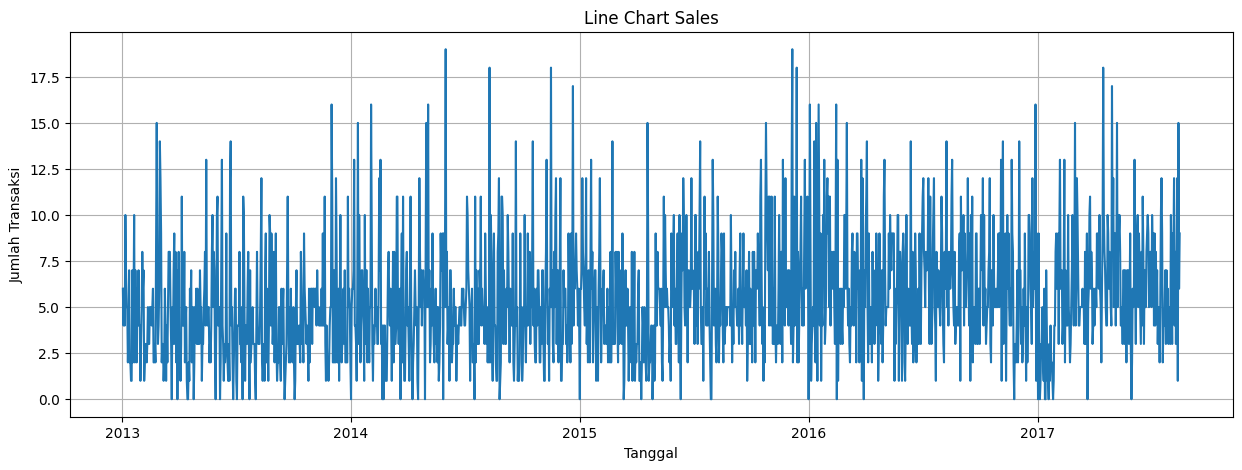

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(df_automotive['sales'])
plt.title('Line Chart Sales')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Transaksi')
plt.grid(True)
plt.show()

In [ ]:
# split data berdasarkan tahun
df_2017 = df_automotive.loc['2017']
df_2016 = df_automotive.loc['2016']
df_2015 = df_automotive.loc['2015']
df_2014 = df_automotive.loc['2014']
df_2013 = df_automotive.loc['2013']

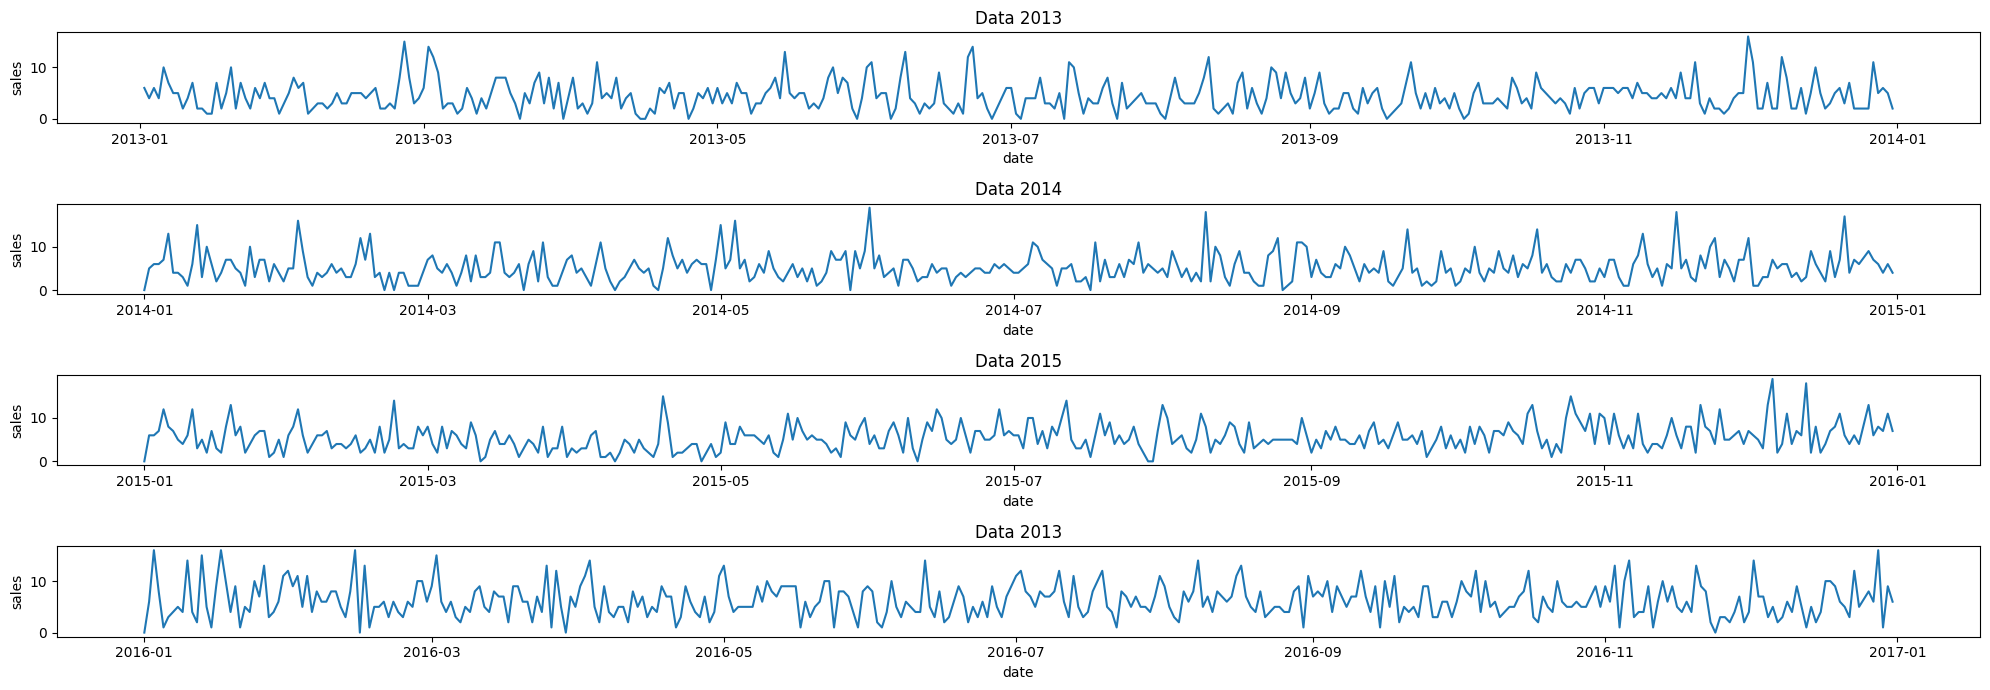

In [ ]:
fig, ax = plt.subplots(4, 1 , figsize=(20,7))

sns.lineplot(x=df_2013.index, y=df_2013['sales'], ax=ax[0])
ax[0].set_title('Data 2013')

sns.lineplot(x=df_2014.index, y=df_2014['sales'], ax=ax[1])
ax[1].set_title('Data 2014')

sns.lineplot(x=df_2015.index, y=df_2015['sales'], ax=ax[2])
ax[2].set_title('Data 2015')

sns.lineplot(x=df_2016.index, y=df_2016['sales'], ax=ax[3])
ax[3].set_title('Data 2013')

plt.tight_layout()
plt.show()

<ipython-input-73-5124d653f135>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_automotive.index.year, y='sales', data=df_automotive, palette='viridis')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-

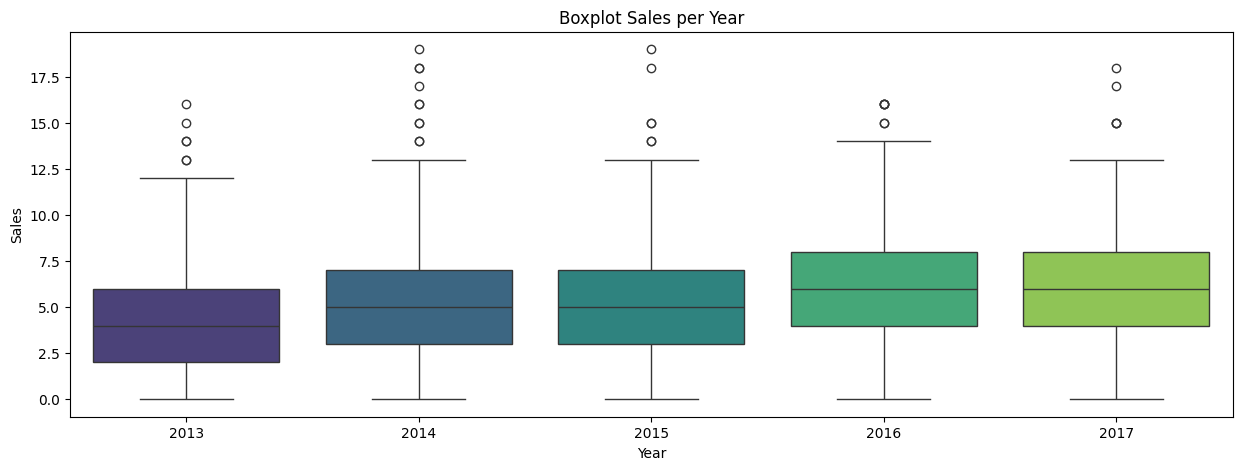

In [ ]:
# Visualisasi data  boxplot
plt.figure(figsize=(15, 5))
sns.boxplot(x=df_automotive.index.year, y='sales', data=df_automotive, palette='viridis')
plt.title('Boxplot Sales per Year')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.show()

In [ ]:
df_automotive['dcoilwtico_diff'] = df_automotive['dcoilwtico_imputed'].diff().dropna()

# Lakukan ADF test pada variabel yang telah di-differencing
adf_test(df_automotive['dcoilwtico_diff'], title='Dcoilwtico Differenced')

Augmented Dickey-Fuller Test: Dcoilwtico Differenced
ADF Test Statistic            -1.093472e+01
p-value                        9.624545e-20
#Lags Used                     2.300000e+01
Number of Observations Used    1.658000e+03
Critical Value (1%)           -3.434300e+00
Critical Value (5%)           -2.863285e+00
Critical Value (10%)          -2.567699e+00



<ipython-input-74-99605cb4a892>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_automotive['dcoilwtico_diff'] = df_automotive['dcoilwtico_imputed'].diff().dropna()


In [ ]:
# Hapus baris yang memiliki nilai NaN pada kolom 'dcoilwtico_diff'
df_automotive_new = df_automotive.dropna(subset=['dcoilwtico_diff'])

# Tampilkan DataFrame baru
df_automotive_new.head()

,sales,onpromotion,dcoilwtico_imputed,dcoilwtico_diff
date,,,,
2013-01-03,4.0,0,92.97,-0.17
2013-01-04,6.0,0,93.12,0.15
2013-01-05,4.0,0,97.30,4.18
2013-01-06,10.0,0,97.30,0.00
2013-01-07,7.0,0,93.20,-4.10


In [ ]:
df_automotive_new1 = df_automotive_new[['sales','onpromotion','dcoilwtico_diff']]
df_automotive_new1.head()

,sales,onpromotion,dcoilwtico_diff
date,,,
2013-01-03,4.0,0,-0.17
2013-01-04,6.0,0,0.15
2013-01-05,4.0,0,4.18
2013-01-06,10.0,0,0.00
2013-01-07,7.0,0,-4.10


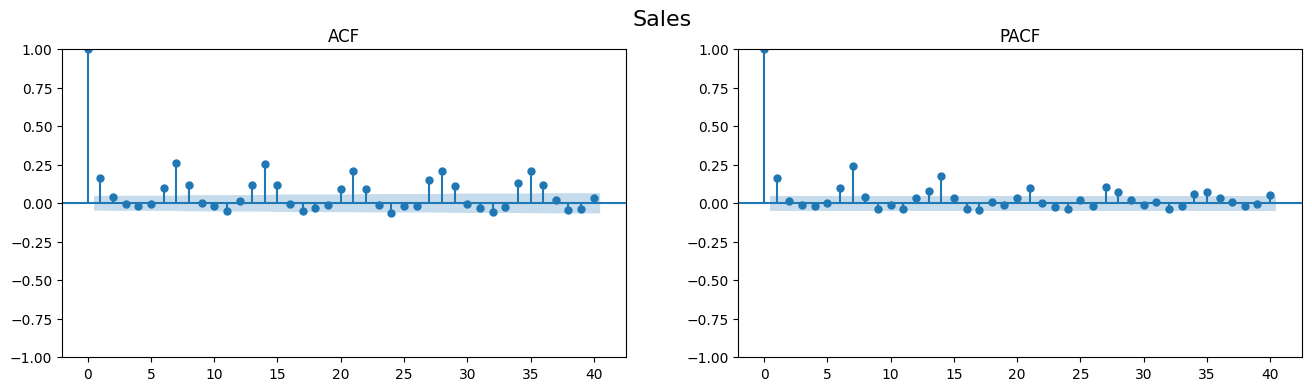

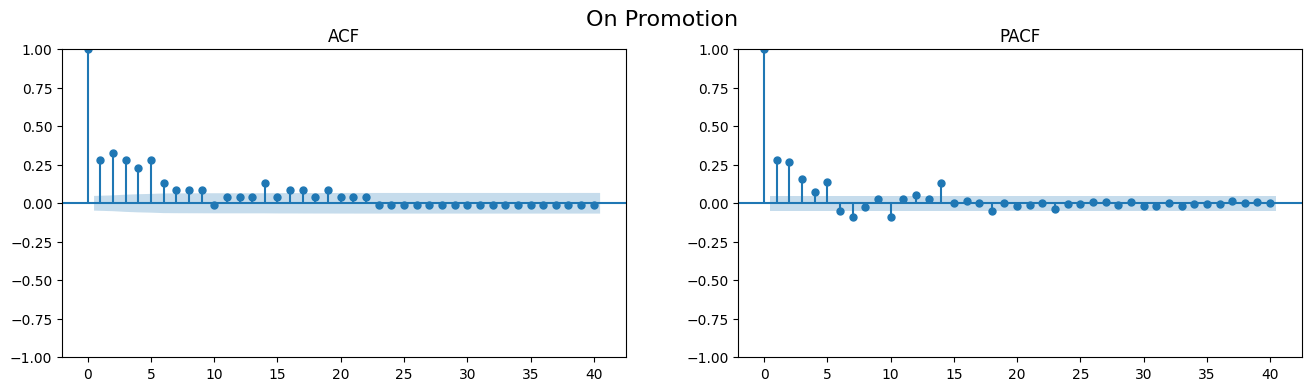

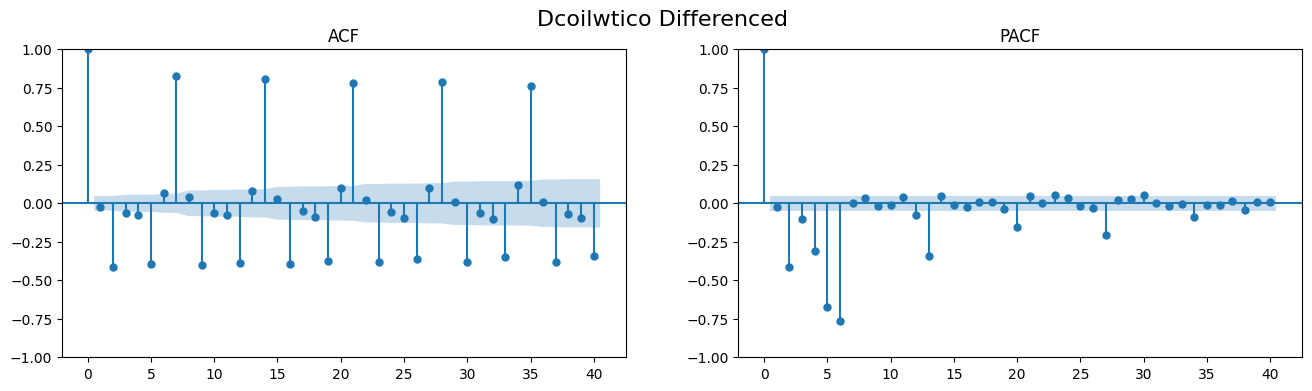

In [ ]:
import statsmodels.api as sm

# Fungsi untuk plot ACF dan PACF
def plot_acf_pacf(series, lags=40, title=''):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    fig.suptitle(title, fontsize=16)

    # Plot ACF
    sm.graphics.tsa.plot_acf(series, lags=lags, ax=axes[0])
    axes[0].set_title('ACF')

    # Plot PACF
    sm.graphics.tsa.plot_pacf(series, lags=lags, ax=axes[1])
    axes[1].set_title('PACF')

    plt.show()

# Plot ACF dan PACF untuk masing-masing variabel
plot_acf_pacf(df_automotive_new1['sales'], title='Sales')
plot_acf_pacf(df_automotive_new1['onpromotion'], title='On Promotion')
plot_acf_pacf(df_automotive_new1['dcoilwtico_diff'], title='Dcoilwtico Differenced')

In [ ]:
df['week'] = df.index.isocalendar().week

In [ ]:
df_automotive_new1.loc[:, 'dayofweek'] = df_automotive_new1.index.dayofweek
df_automotive_new1.head()

,sales,onpromotion,dcoilwtico_diff,dayofweek
date,,,,
2013-01-03,4.0,0,-0.17,3
2013-01-04,6.0,0,0.15,4
2013-01-05,4.0,0,4.18,5
2013-01-06,10.0,0,0.00,6
2013-01-07,7.0,0,-4.10,0


In [ ]:
df_automotive_new1.describe()

,sales,onpromotion,dcoilwtico_diff,dayofweek
count,1682.000000,1682.000000,1682.000000,1682.000000
mean,5.462545,0.011296,-0.027093,2.998811
std,3.256453,0.111198,21.195265,2.001784
min,0.000000,0.000000,-68.830000,0.000000
25%,3.000000,0.000000,-0.970000,1.000000
50%,5.000000,0.000000,0.000000,3.000000
75%,7.000000,0.000000,0.917500,5.000000
max,19.000000,2.000000,67.980000,6.000000


In [ ]:
# evaluate stasioner
result = adfuller(df_automotive['sales'])
print(f'ADF satistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF satistic: -5.633123194827087
p-value: 1.0781125253064122e-06


In [ ]:
df['week'] = df.index.isocalendar().week

**Note** : Data tidak stasioner

## Modeling

### VARMAX

In [ ]:
test_result = adfuller(df_automotive['sales'])
test_result = adfuller(df_automotive['onpromotion'])
test_result = adfuller(df_automotive['dcoilwtico_imputed'])


In [ ]:
from statsmodels.tsa.stattools import adfuller

# Fungsi untuk melakukan ADF test dan mencetak hasilnya
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string())
    print('')

# Lakukan ADF test untuk setiap variabel
adf_test(df_automotive['sales'], title='Sales')
adf_test(df_automotive['onpromotion'], title='On Promotion')
adf_test(df_automotive['dcoilwtico_imputed'], title='Dcoilwtico')

Augmented Dickey-Fuller Test: Sales
ADF Test Statistic            -5.662511e+00
p-value                        9.309993e-07
#Lags Used                     2.000000e+01
Number of Observations Used    1.663000e+03
Critical Value (1%)           -3.434288e+00
Critical Value (5%)           -2.863280e+00
Critical Value (10%)          -2.567696e+00

Augmented Dickey-Fuller Test: On Promotion
ADF Test Statistic            -7.680566e+00
p-value                        1.507855e-11
#Lags Used                     1.300000e+01
Number of Observations Used    1.670000e+03
Critical Value (1%)           -3.434272e+00
Critical Value (5%)           -2.863272e+00
Critical Value (10%)          -2.567692e+00

Augmented Dickey-Fuller Test: Dcoilwtico
ADF Test Statistic               -1.130472
p-value                           0.702768
#Lags Used                       24.000000
Number of Observations Used    1659.000000
Critical Value (1%)              -3.434298
Critical Value (5%)              -2.863284
Crit

In [ ]:
df_automotive['dcoilwtico_diff'] = df_automotive['dcoilwtico_imputed'].diff().dropna()

# Lakukan ADF test pada variabel yang telah di-differencing
adf_test(df_automotive['dcoilwtico_diff'], title='Dcoilwtico Differenced')

Augmented Dickey-Fuller Test: Dcoilwtico Differenced
ADF Test Statistic            -1.093824e+01
p-value                        9.439652e-20
#Lags Used                     2.300000e+01
Number of Observations Used    1.659000e+03
Critical Value (1%)           -3.434298e+00
Critical Value (5%)           -2.863284e+00
Critical Value (10%)          -2.567698e+00



<ipython-input-79-99605cb4a892>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_automotive['dcoilwtico_diff'] = df_automotive['dcoilwtico_imputed'].diff().dropna()


In [ ]:
df_automotive.head()

,sales,onpromotion,dcoilwtico_imputed,dcoilwtico_diff
date,,,,
2013-01-01,0.0,0,97.30,NaN
2013-01-02,6.0,0,93.14,-4.16
2013-01-03,4.0,0,92.97,-0.17
2013-01-04,6.0,0,93.12,0.15
2013-01-05,4.0,0,97.30,4.18


In [ ]:
df_automotive_new = df_automotive.dropna(subset=['dcoilwtico_diff'])

df_automotive_new.head()

,sales,onpromotion,dcoilwtico_imputed,dcoilwtico_diff
date,,,,
2013-01-02,6.0,0,93.14,-4.16
2013-01-03,4.0,0,92.97,-0.17
2013-01-04,6.0,0,93.12,0.15
2013-01-05,4.0,0,97.30,4.18
2013-01-06,10.0,0,97.30,0.00


In [ ]:
df_automotive_new1.loc[:, 'dayofweek'] = df_automotive_new1.index.dayofweek
df_automotive_new1.head()

,sales,onpromotion,dcoilwtico_diff,dayofweek,day_0,day_1,day_2,day_3,day_4,day_5,day_6
date,,,,,,,,,,,
2013-01-02,6.0,0,-4.16,2,0,0,1,0,0,0,0
2013-01-03,4.0,0,-0.17,3,0,0,0,1,0,0,0
2013-01-04,6.0,0,0.15,4,0,0,0,0,1,0,0
2013-01-05,4.0,0,4.18,5,0,0,0,0,0,1,0
2013-01-06,10.0,0,0.00,6,0,0,0,0,0,0,1


In [ ]:
df_automotive_new1.describe()

In [ ]:
# Menambahkan kolom baru untuk setiap hari dalam minggu
for i in range(7):
    df_automotive_new1[f'day_{i}'] = df_automotive_new1['dayofweek'].apply(lambda x: 1 if x == i else 0)

In [ ]:
df_automotive_new1.head()

In [ ]:
import numpy as np
from sklearn.model_selection import ParameterGrid # Import the ParameterGrid class from scikit-learn
from statsmodels.tsa.statespace.varmax import VARMAX
# Definisikan parameter grid
param_grid = {
    'order': [(p, q) for p in range(1, 29) for q in range(1, 8)]
}

# Fungsi untuk melakukan grid search
def grid_search_VARMAX(endog, exog, param_grid):
    best_aic = np.inf
    best_params = None
    best_model = None

    for params in ParameterGrid(param_grid):
        try:
            model = VARMAX(endog, exog=exog, order=params['order'])
            result = model.fit(disp=False)
            if result.aic < best_aic:
                best_aic = result.aic
                best_params = params
                best_model = result
        except Exception as e:
            continue

    return best_model, best_params, best_aic

# Misalkan 'sales' dan 'onpromotion' adalah variabel endogen, dan 'dcoilwtico' adalah variabel eksogen
endog = df[['sales', 'onpromotion']]
exog = df[['dcoilwtico']]

# Lakukan grid search
best_model, best_params, best_aic = grid_search_VARMAX(endog, exog, param_grid)

print(f'Best AIC: {best_aic}')
print(f'Best Parameters: {best_params}')

In [ ]:
import statsmodels.api as sm

# Fungsi untuk plot ACF dan PACF
def plot_acf_pacf(series, lags=40, title=''):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    fig.suptitle(title, fontsize=16)

    # Plot ACF
    sm.graphics.tsa.plot_acf(series, lags=lags, ax=axes[0])
    axes[0].set_title('ACF')

    # Plot PACF
    sm.graphics.tsa.plot_pacf(series, lags=lags, ax=axes[1])
    axes[1].set_title('PACF')

    plt.show()

# Plot ACF dan PACF untuk masing-masing variabel
plot_acf_pacf(df_automotive_new1['sales'], title='Sales')
plot_acf_pacf(df_automotive_new1['onpromotion'], title='On Promotion')
plot_acf_pacf(df_automotive_new1['dcoilwtico_diff'], title='Dcoilwtico Differenced')

In [ ]:
print(f'Shape of train_endog: {train_endog.shape}')
print(f'Shape of train_exog: {train_exog.shape}')


train_exog = train_exog.iloc[:len(train_endog)]

train_exog = train_exog.set_index(train_endog.index)


train_endog = train_endog.astype(float)

model = VARMAX(endog=train_endog, exog=train_exog, order=(1,1))
result = model.fit(disp=True)

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[1]}')
    print(f'p-value: {result[1]}')

adf_test(df['sales'])
adf_test(df['onpromotion'])


In [ ]:
df_automotive_diff = df_automotive.diff().dropna()
df_automotive_diff.plot

In [ ]:
residuals = model_fit.resid[1: ]
fig, ax = plt.subplots(1,2, figsize=(25,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [ ]:
print(df.isnull().sum())

In [ ]:
# Create a sample pandas Series
import pandas as pd # Import the pandas library
series = pd.Series([1, 2, 2, 3, 3, 3, 4, 4, 4, 4]) # Create a pandas Series

unique_values = series.unique() # Calculate the unique values
print(f'Unique values in the series: {unique_values}') # Print the unique values

In [ ]:
# Check if the series is constant before performing the ADF test
def adfuller_test(series):
    if len(series.value_counts()) > 1:
        result = adfuller(series, autolag='AIC')
        print('ADF Statistic:', result[0])
        print('p-value:', result[1])
        print('Number of Lags Used:', result[2])
        print('Critical Values:')
        for key, value in result[4].items():
            print(f'   {key}, {value}')
    else:
        print("series tidak stasioner.")


In [ ]:
adfuller_test(df['Seasonal First Difference'].dropna())

In [ ]:
pip install statsmodels pandas


In [ ]:
from statsmodels.tsa.statespace.varmax import VARMAX

data = {
    'sales': [1, 2, 3, 4, 5],
    'onpromotion': [2, 3, 4, 5, 6],
    'dcoilwtico': [1, 1, 2, 2, 3]
}
df = pd.DataFrame(data)
df.index = pd.date_range(start='2013-01-01', periods=len(df), freq='M')


In [ ]:
df = pd.DataFrame(data)

In [ ]:
train_data = df.iloc[:-2]
test_data = df.iloc[-2:]

In [ ]:
result = adfuller(df['sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

In [ ]:
df[['sales', 'onpromotion', 'dcoilwtico']] = df[['sales', 'onpromotion', 'dcoilwtico']].astype(float)


In [ ]:
print(train_data.corr())

In [ ]:
from sklearn.preprocessing import MaxAbsScaler
scaled_df = df[['sales','onpromotion']]

scaler = MaxAbsScaler()
scaler.fit(scaled_df)
scaled = scaler.transform(scaled_df)
scaled_df = pd.DataFrame(scaled_df, columns=scaled_df.columns)

# use first 1000 days as train
train = scaled_df[:1000]

# simulation window
window = 100 # days look ahead
test = scaled_df[1000:1000]+window

In [ ]:
corr_matrix = scaled_train_df.corr()
print(corr_matrix)

In [ ]:
from statsmodels.tsa.statespace.varmax import VARMAX


if len(df_automotive.columns) < 2:
    from statsmodels.tsa.arima.model import ARIMA
    model = ARIMA(df_automotive['sales'], order=(1, 1, 1))
else:
    sales = df_automotive[['sales', 'onpromotion']]
    model = VARMAX(sales, order=(1, 1))

model_fit = model.fit()

print(model_fit.summary())

Tambah variabel dummy


Pakai varmax

In [ ]:
if 'dcoilwtico' in data.columns:
    df_exog = data[['dcoilwtico_imputed']]
else:

    print("Column 'dcoilwtico' not found in DataFrame.")
    df_exog = pd.DataFrame()

In [ ]:
df_exog = pd.DataFrame({'dcoilwtico_imputed': [0] * len(data)})

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['sales'])
autocorrelation_plot(df['onpromotion'])
plt.show()


In [ ]:
# Step 4: Split data untuk training dan testing
train_endog = df_endog[:104]  # Data training endogen
test_endog = df_endog[104:]   # Data testing endogen

In [ ]:
train_exog = df_exog[:104]  # Data training eksogen
test_exog = df_exog[104:]   # Data testing eksogen

In [ ]:
train_exog = train_exog.set_index(train_endog.index)

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Check stationarity of each endogenous variable
for column in train_endog.columns:
    result = adfuller(train_endog[column])
    print(f'{column}: ADF Statistic = {result[1]}, p-value = {result[1]}')


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_endog_scaled = scaler.fit_transform(train_endog)
train_exog_scaled = scaler.fit_transform(train_exog)


In [ ]:
train_endog_log = np.log(train_endog)

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.varmax import VARMAX

# Sample data (replace with your actual data)
data = {'Column1': [10, 12, 15, 13, 16],
        'Column2': [25, 28, 22, 26, 24]}
train_endog = pd.DataFrame(data)

train_endog_diff = train_endog.diff().dropna()


for column in train_endog_diff.columns:

    if train_endog_diff[column].nunique() > 1:

        result = adfuller(train_endog_diff[column])
        print(f'ADF Statistic for {column}: {result[0]}')
        print(f'p-value for {column}: {result[1]}')


        if result[1] < 0.05:

            print(f'{column} is stationary')
        else:
            print(f'{column} is not stationary, perlu diproses lebih lanjut.')
    else:
        print(f'{column} is constant after differencing, cannot perform ADF test.')

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(14,12))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['sales'],lags=59,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['sales'],lags=59,ax=ax2)
fig = plt.figure(figsize=(14,12))


In [ ]:
import statsmodels.api as sm

In [ ]:
df['forecast'] = result.predict(start = 90, end=103, dynamic= True)
df[['sales', 'forecast']].plot(figsize=(12, 8))

In [ ]:
from pandas.tseries.offsets import DateOffset
future_datatest_df=pd.DataFrame(df['sales'])
future_datatest_df=pd.DataFrame(df['onpromotion'])

In [ ]:
future_datatest_df.tail()

In [ ]:
future_df=pd.DataFrame(df['sales'])

In [ ]:
future_df['forecast'] = result.predict(start = 104, end=120, dynamic= True)
future_df[['sales','forecast']].plot(figsize=(12,8))

In [ ]:
# Predict data
start_index = 0
end_index = len(df_automotive)
# Forecast
forecast = model_fit.predict(start=start_index, end=end_index)
# Actual
actual = df_automotive['sales']
# Plot
plt.figure(figsize=(10, 5))
plt.plot(forecast, color='blue', label='Forecast')
plt.plot(actual, color='red', label='Actual')
plt.title('Forecast vs Actual')
plt.legend()
plt.show()

###VARX

In [ ]:
df_automotive_varx = df_automotive.copy()

In [ ]:
adf_sales_varx = adfuller(df_automotive_varx['sales'])
adf_onpromotion_varx = adfuller(df_automotive_varx['onpromotion'])
p_value_sales_varx = adf_sales_varx[1]
p_value_onpromotion_varx = adf_onpromotion_varx[1]
print(p_value_sales_varx)
print(p_value_onpromotion_varx)

9.309992645426182e-07
1.5078548437282953e-11


In [ ]:
df_automotive_varx['sales_diff'] = df_automotive_varx['sales'].diff()
df_automotive_varx['onpromotion_diff'] = df_automotive_varx['onpromotion'].diff()

In [ ]:
df_automotive_varx = df_automotive_varx.drop('sales', axis=1)
df_automotive_varx = df_automotive_varx.drop('onpromotion', axis=1)


In [ ]:
df_automotive_varx['month'] = df_automotive_varx.index.month
df_automotive_varx = pd.get_dummies(df_automotive_varx, columns=['month'], drop_first=True)

In [ ]:
df_automotive_varx.head()

,dcoilwtico_imputed,sales_diff,onpromotion_diff,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,,
2013-01-01,97.30,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False
2013-01-02,93.14,6.0,0.0,False,False,False,False,False,False,False,False,False,False,False
2013-01-03,92.97,-2.0,0.0,False,False,False,False,False,False,False,False,False,False,False
2013-01-04,93.12,2.0,0.0,False,False,False,False,False,False,False,False,False,False,False
2013-01-05,97.30,-2.0,0.0,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
train_data_varx = df_automotive_varx['2013-01-01':'2016-12-31']
test_data_varx = df_automotive_varx['2017-01-01':'2017-12-31']

In [ ]:
endog_train_varx = train_data_varx[['sales_diff', 'onpromotion_diff']]
exog_train_varx = train_data_varx.drop(['sales_diff', 'onpromotion_diff'], axis=1)
endog_test_varx = test_data_varx[['sales_diff', 'onpromotion_diff']]
exog_test_varx = test_data_varx.drop(['sales_diff', 'onpromotion_diff'], axis=1)

In [ ]:
endog_train_varx = endog_train_varx.apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)
exog_train_varx = exog_train_varx.apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)
endog_test_varx = endog_test_varx.apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)
exog_test_varx = exog_test_varx.apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)


time series plot sales,onpromotion


In [ ]:
from statsmodels.tsa.api import VAR
model_VARX = VAR(endog_train_varx, exog=exog_train_varx)
model_VARX_fit = model_VARX.fit()
lag_order = model_VARX_fit.k_ar
print(model_VARX_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 29, Sep, 2024
Time:                     12:03:43
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -1.48469
Nobs:                     1456.00    HQIC:                  -1.55294
Log likelihood:          -2941.84    FPE:                   0.203203
AIC:                     -1.59355    Det(Omega_mle):        0.199080
--------------------------------------------------------------------
Results for equation sales_diff
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -2.105092         0.464189           -4.535           0.000
dcoilwtico_imputed          0.027981         0.004008            6.982           0.000
month_2                    -0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
prediction_varx = model_VARX_fit.forecast(y=endog_train_varx.values[-lag_order:], steps=len(endog_test_varx), exog_future=exog_test_varx.values)

In [ ]:
prediction_df_varx = pd.DataFrame(prediction_varx, index=test_data_varx.index, columns=['sales_diff_pred', 'onpromotion_diff_pred'])

In [ ]:
prediction_df_varx['sales_pred'] = prediction_df_varx['sales_diff_pred'].cumsum() + df_automotive_varx['sales_diff'].iloc[len(train_data_varx)-1]
prediction_df_varx['onpromotion_pred'] = prediction_df_varx['onpromotion_diff_pred'].cumsum() + df_automotive_varx['onpromotion_diff'].iloc[len(train_data_varx)-1]

Text(0.5, 1.0, 'Prediksi Penjualan dengan VARX')

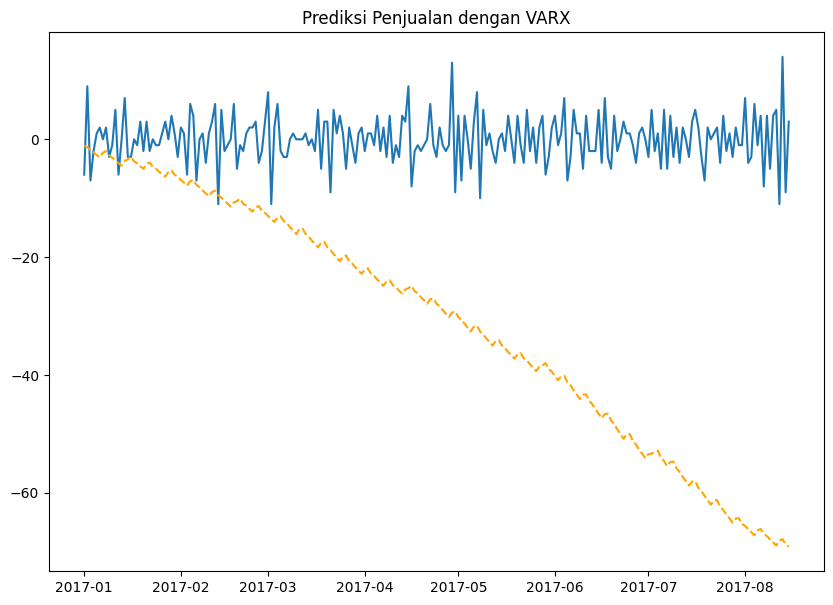

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(test_data_varx['sales_diff'], label='Aktual')
plt.plot(prediction_df_varx['sales_pred'], label='Prediksi', linestyle='--', color='orange')
plt.title("Prediksi Penjualan dengan VARX")

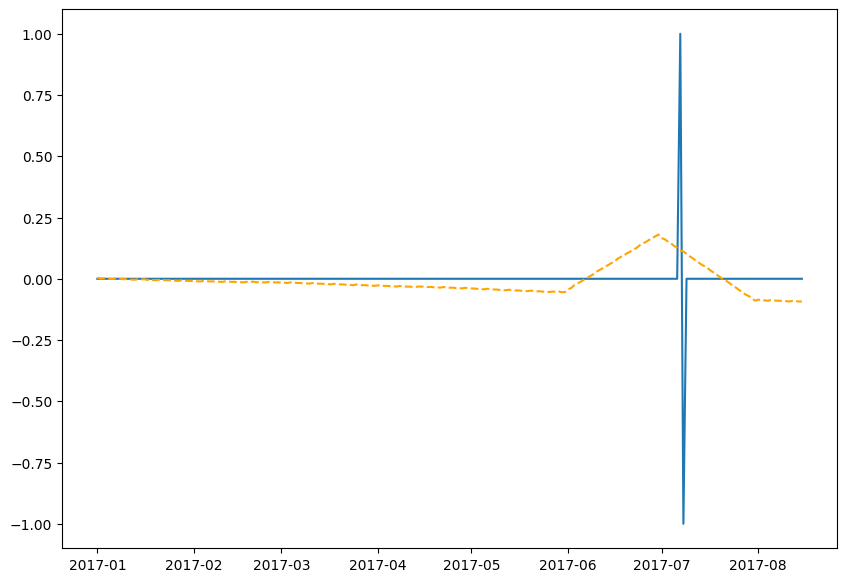

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(test_data_varx['onpromotion_diff'], label='Aktual')
plt.plot(prediction_df_varx['onpromotion_pred'], label='Prediksi', linestyle='--', color='orange')

### Stacked LSTM

In [ ]:
# Scailing and split dataset
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X = df_automotive[['dcoilwtico_imputed']].copy()
y = df_automotive[['sales','onpromotion']].copy()

X = x_scaler.fit_transform(X)
y = y_scaler.fit_transform(y.values.reshape(-1, 1))

In [ ]:
def load_data(X, seq_len, train_size=0.8, val_size=0.1):
    amount_of_features = X.shape[1]
    X_mat = X
    sequence_length = seq_len + 1
    data = []

    # Membuat urutan data berdasarkan sequence length
    for index in range(len(X_mat) - sequence_length):
        data.append(X_mat[index: index + sequence_length])

    data = np.array(data)

    # Membagi data berdasarkan train, validation, dan test ratio
    train_split = int(round(train_size * data.shape[0]))
    val_split = int(round((train_size + val_size) * data.shape[0]))

    train_data = data[:train_split]
    val_data = data[train_split:val_split]
    test_data = data[val_split:]

    # Membagi input (x) dan target (y)
    X_train = train_data[:, :-1]
    y_train = train_data[:, -1][:,-1]

    X_val = val_data[:, :-1]
    y_val = val_data[:, -1][:,-1]

    X_test = test_data[:, :-1]
    y_test = test_data[:, -1][:,-1]

    # Mereshape input menjadi 3D: (samples, timesteps, features)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
window = 7
X = np.hstack((X, y))
X_train, y_train, X_val, y_val, X_test, y_test = load_data(X, window)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape )

(1341, 7, 3) (1341,) (168, 7, 3) (168,) (167, 7, 3) (167,)


In [ ]:
# Membuat earlystop callback
callbacks_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [ ]:
tf.random.set_seed(42)

# LSTM architecture
model_lstm = Sequential()
# First LSTM layer with Dropout regularisation
model_lstm.add(tf.keras.layers.LSTM(units=128, input_shape=(window, 3), return_sequences=True, activation='relu'))
model_lstm.add(Dropout(0.2))

# Second LSTM layer
model_lstm.add(tf.keras.layers.LSTM(units=128, return_sequences=True, activation='relu'))
model_lstm.add(Dropout(0.2))

# Third LSTM layer
model_lstm.add(tf.keras.layers.LSTM(units=128, return_sequences=True, activation='relu'))
model_lstm.add(Dropout(0.2))

# Fourth LSTM layer
model_lstm.add(tf.keras.layers.LSTM(units=64))
model_lstm.add(Dropout(0.5))

# The output layer
model_lstm.add(Dense(units=50, kernel_initializer='uniform', activation='tanh'))
model_lstm.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))

# Compiling the RNN
model_lstm.compile(loss="mae",
                   optimizer=tf.keras.optimizers.Adam())

# Fitting to the training set
history_lstm = model_lstm.fit(X_train,
                              y_train,
                              epochs=100,
                              batch_size=32,
                              validation_data=(X_val, y_val),
                              verbose=1,
                              callbacks=[callbacks_early])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - loss: 0.2274 - val_loss: 0.1411
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.1370 - val_loss: 0.1419
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.1359 - val_loss: 0.1404
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.1329 - val_loss: 0.1375
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.1335 - val_loss: 0.1380
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.1328 - val_loss: 0.1361
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.1324 - val_loss: 0.1354
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.1332 - val_loss: 0.1365
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.1303 - val_loss: 0.1363
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.1323 - val_loss: 0.1342
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.1313 - val_loss: 0.1335
Epoch 12/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/ste

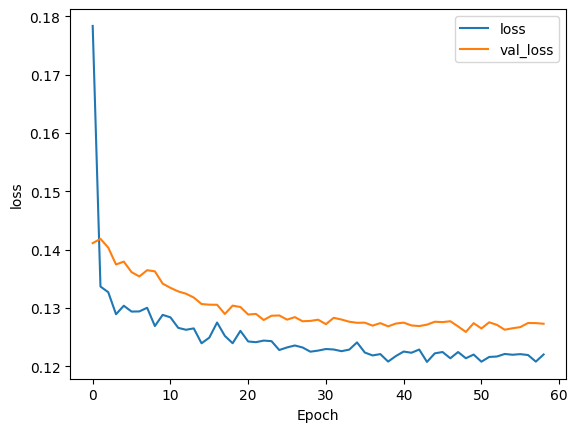

In [ ]:
pd.DataFrame(history_lstm.history).plot()
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
def make_preds(model, input_data, scaler):
  """
  Uses model to make predictions on input_data and inverse to scale actual

  Parameters
  ----------
  model: trained model
  input_data: windowed input data (same kind of data model was trained on)
  scaler: fitted MinMaxScaler used during data preprocessing

  Returns model predictions on input_data.
  """

  preds = model.predict(input_data)
  preds_invers = scaler.inverse_transform(preds)
  return tf.squeeze(preds_invers) # return 1D array of predictions

In [ ]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  mse = tf.reduce_mean(tf.square(y_true - y_pred)) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)

  # Convert Tensors to numpy for r2_score calculation
  y_true_np = y_true.numpy()
  y_pred_np = y_pred.numpy()
  r2 = sk.metrics.r2_score(y_true_np, y_pred_np)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "R2_score" : r2}

In [ ]:
model_lstm_preds = make_preds(model_lstm, X_test, y_scaler)
len(model_lstm_preds), model_lstm_preds[:5]

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step


(168,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([4.1271615, 4.9347606, 5.1051035, 5.1487956, 6.4168515],
       dtype=float32)>)

In [ ]:
# ubah scale y_test ke actual
y_test_actual = y_scaler.inverse_transform(y_test.reshape(168,1)).reshape(168)
y_test_actual[:5]

array([ 7., 15.,  4.,  6., 12.])

In [ ]:
lstm_result = evaluate_preds(y_test_actual, model_lstm_preds)
lstm_result

{'mae': 2.374272,
 'mse': 9.760712,
 'rmse': 3.1242137,
 'R2_score': -0.0343097448348999}

In [ ]:
timesteps = df_automotive.index.to_numpy()
len(timesteps), timesteps[:5]

(1684,
 array(['2013-01-01T00:00:00.000000000', '2013-01-02T00:00:00.000000000',
        '2013-01-03T00:00:00.000000000', '2013-01-04T00:00:00.000000000',
        '2013-01-05T00:00:00.000000000'], dtype='datetime64[ns]'))

In [ ]:
# Create fuction for plot time series
def plot_time_series(timesteps, values, format='.', label=None, start=0, end=None, ylabel=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.ylabel(ylabel)
  plt.xlabel('Time')
  if label :
    plt.legend()
  plt.grid(True)

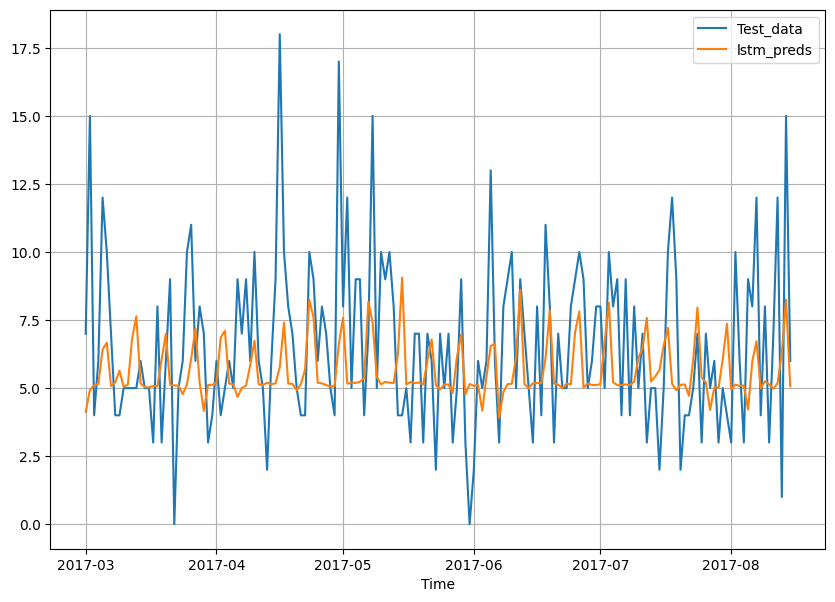

In [ ]:
plt.figure(figsize=(10, 7))
# Membandingkan Test label dengan prediction
plot_time_series(timesteps=timesteps[-len(y_test):], values=y_test_actual, format="-", label="Test_data")
plot_time_series(timesteps=timesteps[-len(y_test):], values=model_lstm_preds, format="-", label="lstm_preds")

In [ ]:
!pip install --no-cache-dir scikit-fda

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 133.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 101.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 94.7 MB/s eta 0:00:00


In [ ]:
from skfda.representation.grid import FDataGrid
from scipy.signal import savgol_filter
from skfda.representation.basis import BSpline
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.misc.regularization import L2Regularization
from skfda.ml.regression import LinearRegression as FunctionalLinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.signal import savgol_filter

In [ ]:
df_far_automotive = df_automotive.copy()
df_far_automotive.head()

,sales,onpromotion,dcoilwtico_imputed
date,,,
2013-01-01,0.0,0,97.30
2013-01-02,6.0,0,93.14
2013-01-03,4.0,0,92.97
2013-01-04,6.0,0,93.12
2013-01-05,4.0,0,97.30


In [ ]:
df_far_automotive['sales'] = (df_far_automotive['sales'] - df_far_automotive['sales'].mean()) / df_far_automotive['sales'].std()
df_far_automotive['onpromotion'] = (df_far_automotive['onpromotion'] - df_far_automotive['onpromotion'].mean()) / df_far_automotive['onpromotion'].std()
df_far_automotive['dcoilwtico_imputed'] = (df_far_automotive['dcoilwtico_imputed'] - df_far_automotive['dcoilwtico_imputed'].mean()) / df_far_automotive['dcoilwtico_imputed'].std()

In [ ]:
index_array = df_far_automotive.index.to_numpy()

In [ ]:
fd_sales = FDataGrid(data_matrix=df_far_automotive['sales'].values, grid_points=index_array.astype(float))
fd_onpromotion = FDataGrid(data_matrix=df_far_automotive['onpromotion'].values, grid_points=index_array.astype(float))
fd_dcoilwtico_imputed = FDataGrid(data_matrix=df_far_automotive['dcoilwtico_imputed'].values, grid_points=index_array.astype(float))

In [ ]:
def moving_average_smoothing(data, window_size=3):
    return pd.Series(data).rolling(window=window_size, center=True).mean().values


In [ ]:
fd_sales_smoothed = moving_average_smoothing(fd_sales.data_matrix.flatten(), window_size=3)
fd_onpromotion_smoothed = moving_average_smoothing(fd_onpromotion.data_matrix.flatten(), window_size=3)
fd_dcoilwtico_imputed_smoothed = moving_average_smoothing(fd_dcoilwtico_imputed.data_matrix.flatten(), window_size=3)


In [ ]:
lag = 1
X = np.stack([fd_sales_smoothed[:-lag],
              fd_onpromotion_smoothed[:-lag],
              fd_dcoilwtico_imputed_smoothed[:-lag]], axis=1)
y = fd_sales_smoothed[lag:]

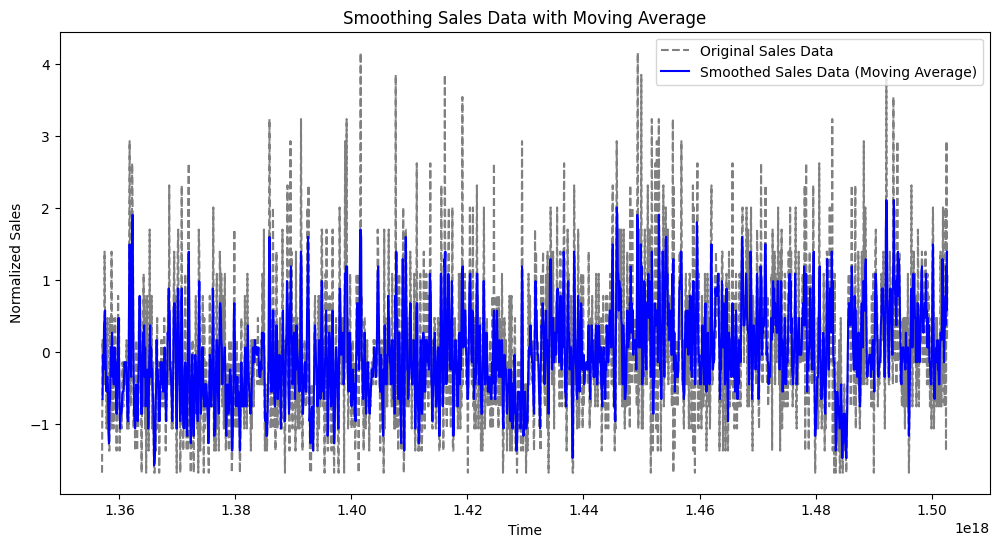

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(index_array.astype(float), df_far_automotive['sales'], label='Original Sales Data', color='grey', linestyle='dashed')
plt.plot(index_array.astype(float)[:-lag], fd_sales_smoothed[:-lag], label='Smoothed Sales Data (Moving Average)', color='blue')
plt.title("Smoothing Sales Data with Moving Average")
plt.xlabel("Time")
plt.ylabel("Normalized Sales")
plt.legend()
plt.show()

In [ ]:
train_size = 0.6
val_size = 0.2
test_size = 0.2

train_index = int(len(X) * train_size)
val_index = int(len(X) * (train_size + val_size))

X_train, y_train = X[:train_index], y[:train_index]
X_val, y_val = X[train_index:val_index], y[train_index:val_index]
X_test, y_test = X[val_index:], y[val_index:]

X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)
X_val = np.nan_to_num(X_val)
y_val = np.nan_to_num(y_val)
X_test = np.nan_to_num(X_test)
y_test = np.nan_to_num(y_test)


In [ ]:
VAR = FunctionalLinearRegression()


In [ ]:
FAR.fit(X_train, y_train)
y_val_pred = FAR.predict(X_val)
y_test_pred = FAR.predict(X_test)
val_mse = mean_squared_error(y_val.flatten(), y_val_pred.flatten())
val_mae = mean_absolute_error(y_val.flatten(), y_val_pred.flatten())
val_r2 = r2_score(y_val.flatten(), y_val_pred.flatten())

print(f'Validation Mean Squared Error (MSE): {val_mse}')
print(f'Validation Mean Absolute Error (MAE): {val_mae}')
print(f'Validation R² Score: {val_r2}')

Validation Mean Squared Error (MSE): 0.2514785754888154
Validation Mean Absolute Error (MAE): 0.3923452369049901
Validation R² Score: 0.28585596000939095


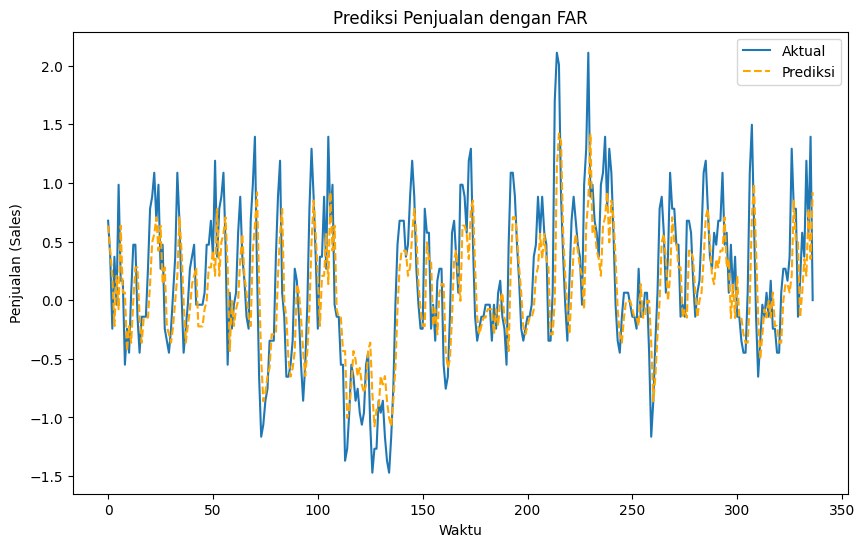

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(y_test)), y_test.flatten(), label='Aktual')
plt.plot(np.arange(len(y_test)), y_test_pred.flatten(), label='Prediksi', linestyle='--', color='orange')
plt.title("Prediksi Penjualan dengan FAR")
plt.xlabel("Waktu")
plt.ylabel("Penjualan (Sales)")
plt.legend()
plt.show()

### Bi-LSTM

In [ ]:
import time
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

Window = 7

In [ ]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
x = df_automotive[['dcoilwtico_imputed']].copy()
y = df_automotive['sales', 'onpromotion'].copy()

x[['sales', 'onpromotion']] = x_scaler.fit_transform(x)
y = y_scaler.fit_transform(y.values.reshape(-1, 1))

NameError: name 'df_automotive' is not defined

tambahkan variabel dummy

In [ ]:
def load_data(X, seq_len, train_size=0.5, val_size=0.25):
    amount_of_features = X.shape[1]
    X_mat = X
    sequence_length = seq_len + 1
    data = []

    # Membuat urutan data berdasarkan sequence length
    for index in range(len(X_mat) - sequence_length):
        data.append(X_mat[index: index + sequence_length])

    data = np.array(data)

    # Membagi data berdasarkan train, validation, dan test ratio
    train_split = int(round(train_size * data.shape[0]))
    val_split = int(round((train_size + val_size) * data.shape[0]))

    train_data = data[:train_split]
    val_data = data[train_split:val_split]
    test_data = data[val_split:]

    # Membagi input (x) dan target (y)
    X_train = train_data[:, :-1]
    y_train = train_data[:, -1][:,-1]

    X_val = val_data[:, :-1]
    y_val = val_data[:, -1][:,-1]

    X_test = test_data[:, :-1]
    y_test = test_data[:, -1][:,-1]

    # Mereshape input menjadi 3D: (samples, timesteps, features)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
window = 7
X = np.hstack((x, y))
X_train, y_train, X_val, y_val, X_test, y_test = load_data(X, window)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape )

(838, 7, 3) (838,) (419, 7, 3) (419,) (419, 7, 3) (419,)


In [ ]:
# Stack LSTM architecture
model3 = Sequential()
# Bidirectional LSTM layer with Dropout regularisation
model3.add (Bidirectional(LSTM(units=9), input_shape=(window,3)))
model3.add(Dropout(0.2))

# The output layer
model3.add(Dense(units=9, kernel_initializer='uniform', activation='tanh'))
model3.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))

earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
callbacks_list = [earlystop]

# Compiling the RNN
model3.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
start = time.time()
historybiLSTM=model3.fit(X_train, y_train,epochs=100, batch_size=17, validation_data=(X_val, y_val), verbose=1,callbacks=callbacks_list)
print ('compilation time : ', time.time() - start)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.5899 - val_loss: 0.1271
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1460 - val_loss: 0.1780
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0276 - val_loss: 0.1362
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0275 - val_loss: 0.1192
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0238 - val_loss: 0.1037
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0192 - val_loss: 0.0924
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0184 - val_loss: 0.0888
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0162 - val_loss: 0.0870
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0178 - val_loss: 0.0860
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0184 - val_loss: 0.0849
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0191 - val_loss: 0.0840
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0163 - val_l

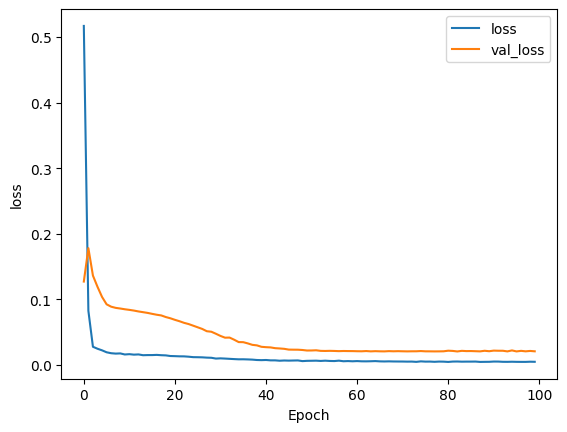

In [ ]:
pd.DataFrame(historybiLSTM.history).plot()
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
trainPredict = model3.predict(X_train)
testPredict = model3.predict(X_test)

trainPredict = y_scaler.inverse_transform(trainPredict)
trainY = y_scaler.inverse_transform([y_train])
testPredict = y_scaler.inverse_transform(testPredict)
testY = y_scaler.inverse_transform([y_test])

plot_predicted = testPredict.copy()
plot_predicted = plot_predicted.reshape(419, 1)
plot_actual = testY.copy()
plot_actual = plot_actual.reshape(419, 1)
print(plot_actual.shape)
print(plot_predicted.shape)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
(419, 1)
(419, 1)


In [ ]:
trainScore = mean_squared_error(trainY[0], trainPredict[:,0]) ** .5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = mean_squared_error(testY[0], testPredict[:,0]) ** .5
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 5.40 RMSE
Test Score: 10.36 RMSE


In [ ]:
# Create fuction for plot time series
def plot_time_series(timesteps, values, format='.', label=None, start=0, end=None, ylabel=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.ylabel(ylabel)
  plt.xlabel('Time')
  if label :
    plt.legend()
  plt.grid(True)

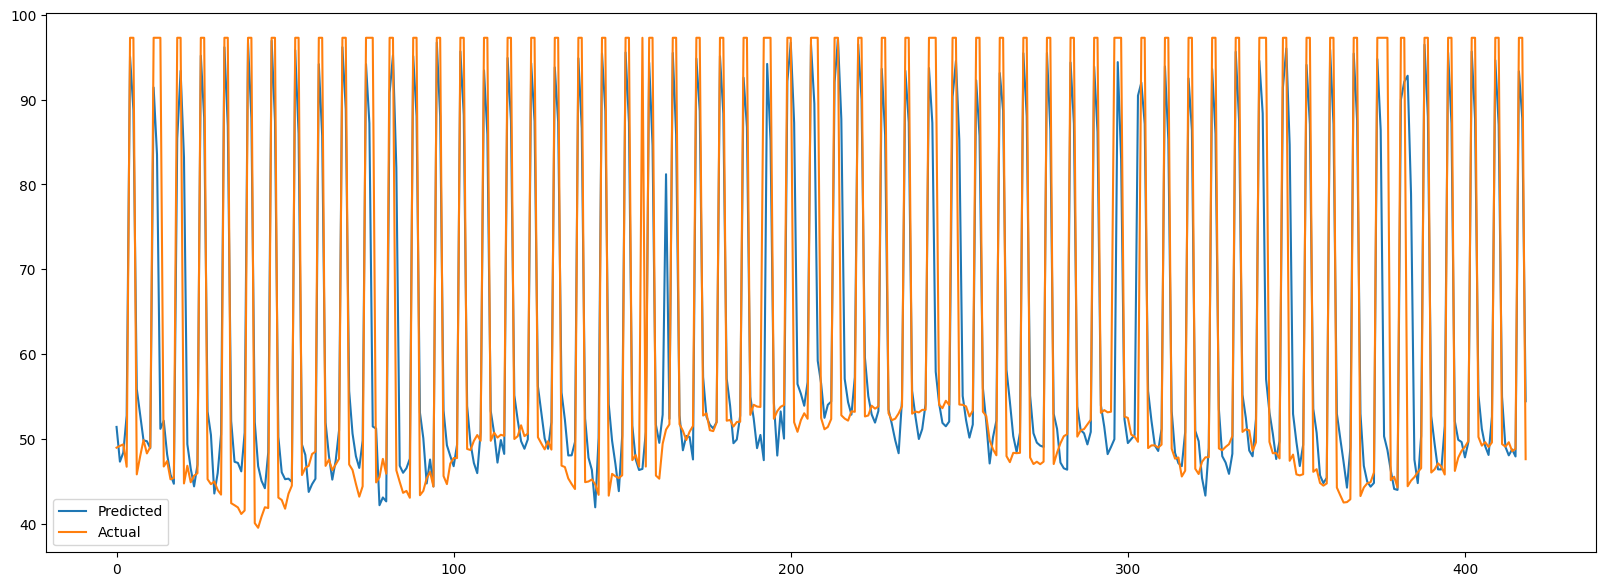

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(pd.DataFrame(plot_predicted), label='Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Actual')
plt.legend(loc='best')
plt.show()


In [ ]:
df_automotive_varx = df_automotive.copy()

In [ ]:
adf_sales_varx = adfuller(df_automotive_varx['sales'])
adf_onpromotion_varx = adfuller(df_automotive_varx['onpromotion'])
p_value_sales_varx = adf_sales_varx[1]
p_value_onpromotion_varx = adf_onpromotion_varx[1]
print(p_value_sales_varx)
print(p_value_onpromotion_varx)

9.309992645426182e-07
1.5078548437282953e-11


In [ ]:
df_automotive_varx['sales_diff'] = df_automotive_varx['sales'].diff()
df_automotive_varx['onpromotion_diff'] = df_automotive_varx['onpromotion'].diff()

In [ ]:
df_automotive_varx = df_automotive_varx.drop('sales', axis=1)
df_automotive_varx = df_automotive_varx.drop('onpromotion', axis=1)


In [ ]:
df_automotive_varx['month'] = df_automotive_varx.index.month
df_automotive_varx = pd.get_dummies(df_automotive_varx, columns=['month'], drop_first=True)

In [ ]:
df_automotive_varx.head()

,dcoilwtico_imputed,sales_diff,onpromotion_diff,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,,
2013-01-01,97.30,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False
2013-01-02,93.14,6.0,0.0,False,False,False,False,False,False,False,False,False,False,False
2013-01-03,92.97,-2.0,0.0,False,False,False,False,False,False,False,False,False,False,False
2013-01-04,93.12,2.0,0.0,False,False,False,False,False,False,False,False,False,False,False
2013-01-05,97.30,-2.0,0.0,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
train_data_varx = df_automotive_varx['2013-01-01':'2016-12-31']
test_data_varx = df_automotive_varx['2017-01-01':'2017-12-31']

In [ ]:
endog_train_varx = train_data_varx[['sales_diff', 'onpromotion_diff']]
exog_train_varx = train_data_varx.drop(['sales_diff', 'onpromotion_diff'], axis=1)
endog_test_varx = test_data_varx[['sales_diff', 'onpromotion_diff']]
exog_test_varx = test_data_varx.drop(['sales_diff', 'onpromotion_diff'], axis=1)

In [ ]:
endog_train_varx = endog_train_varx.apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)
exog_train_varx = exog_train_varx.apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)
endog_test_varx = endog_test_varx.apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)
exog_test_varx = exog_test_varx.apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)


In [ ]:
from statsmodels.tsa.api import VAR
model_VARX = VAR(endog_train_varx, exog=exog_train_varx)
model_VARX_fit = model_VARX.fit()
lag_order = model_VARX_fit.k_ar
print(model_VARX_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 29, Sep, 2024
Time:                     12:03:43
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -1.48469
Nobs:                     1456.00    HQIC:                  -1.55294
Log likelihood:          -2941.84    FPE:                   0.203203
AIC:                     -1.59355    Det(Omega_mle):        0.199080
--------------------------------------------------------------------
Results for equation sales_diff
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -2.105092         0.464189           -4.535           0.000
dcoilwtico_imputed          0.027981         0.004008            6.982           0.000
month_2                    -0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
prediction_varx = model_VARX_fit.forecast(y=endog_train_varx.values[-lag_order:], steps=len(endog_test_varx), exog_future=exog_test_varx.values)

In [ ]:
prediction_df_varx = pd.DataFrame(prediction_varx, index=test_data_varx.index, columns=['sales_diff_pred', 'onpromotion_diff_pred'])

In [ ]:
prediction_df_varx['sales_pred'] = prediction_df_varx['sales_diff_pred'].cumsum() + df_automotive_varx['sales_diff'].iloc[len(train_data_varx)-1]
prediction_df_varx['onpromotion_pred'] = prediction_df_varx['onpromotion_diff_pred'].cumsum() + df_automotive_varx['onpromotion_diff'].iloc[len(train_data_varx)-1]

Text(0.5, 1.0, 'Prediksi Penjualan dengan VARX')

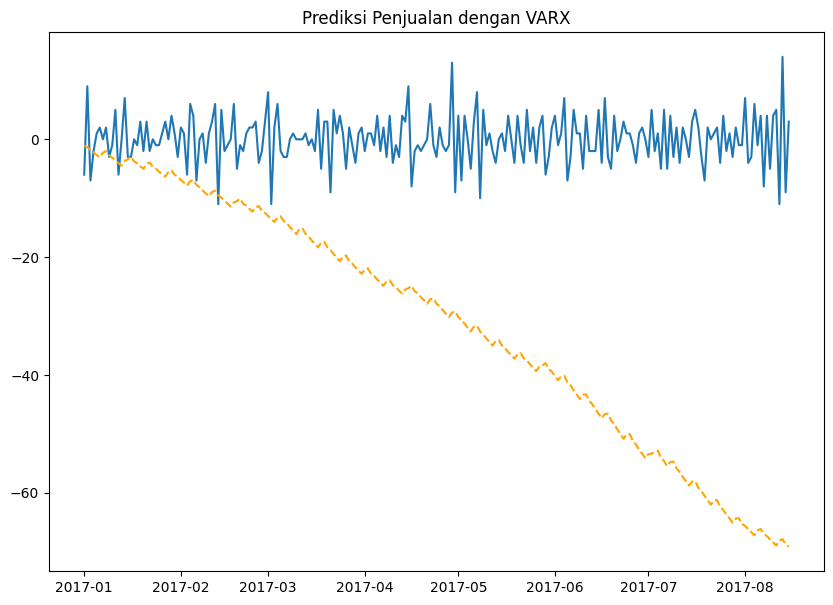

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(test_data_varx['sales_diff'], label='Aktual')
plt.plot(prediction_df_varx['sales_pred'], label='Prediksi', linestyle='--', color='orange')
plt.title("Prediksi Penjualan dengan VARX")

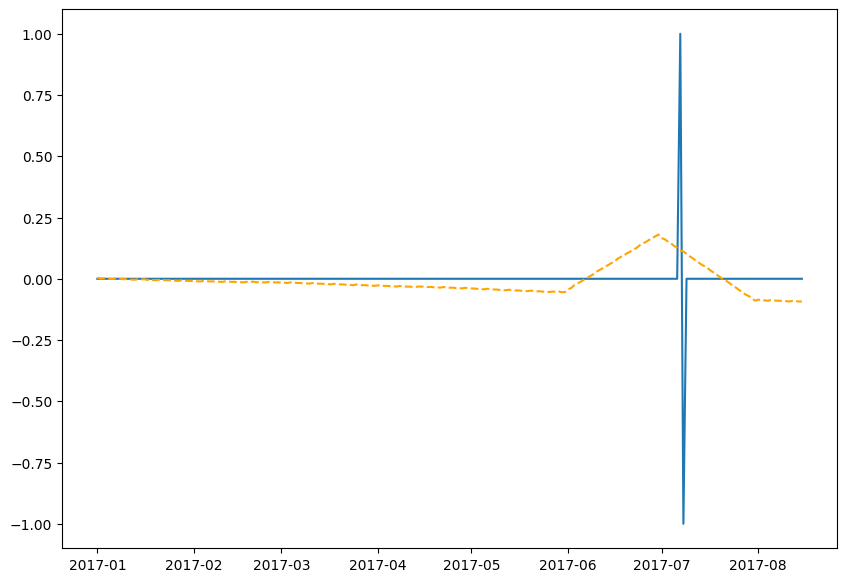

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(test_data_varx['onpromotion_diff'], label='Aktual')
plt.plot(prediction_df_varx['onpromotion_pred'], label='Prediksi', linestyle='--', color='orange')